In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import diffimTests as dit

import warnings
warnings.filterwarnings('ignore')

In [2]:
testResults2 = dit.multi.runTest(flux=620.*np.sqrt(2.), n_varSources=50, n_sources=1000,
                                templateNoNoise=False, skyLimited=False,
                                sky=[300., 300.], sourceFluxRange=(500,30000),
                                remeasurePsfs=[False, False], avoidAllOverlaps=25., 
                                zogyImageSpace=False,
                                returnObjs=True, printErrs=True)

In [5]:
tr = testResults2
tr['resultInputPsf']

{'ALstack': {'FN': 14, 'FP': 11, 'TP': 36},
 'ALstack_decorr': {'FN': 22, 'FP': 1, 'TP': 28},
 'SZOGY': {'FN': 50, 'FP': 0, 'TP': 0},
 'ZOGY': {'FN': 23, 'FP': 5, 'TP': 27}}

(2.0, 10.0)

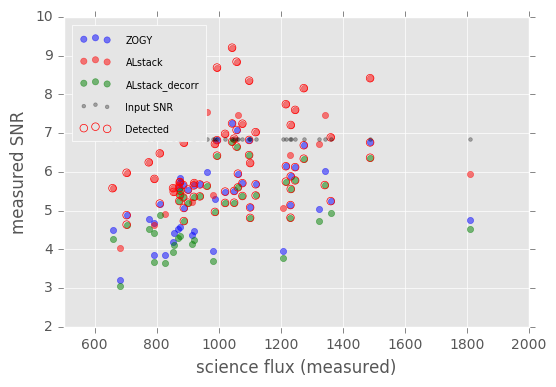

In [6]:
obj = tr['objs'][0]
df, _ = obj.doPlotWithDetectionsHighlighted(runTestResult=tr['resultInputPsf'], xaxisIsScienceForcedPhot=True)
plt.xlim(500, 2000); plt.ylim(2., 10.)

In [5]:
df.head()

,inputFlux,templateFlux,scienceFlux,inputId,inputCentroid_x,inputCentroid_y,inputSNR,ZOGY_SNR,ZOGY_flux,ZOGY_fluxSigma,ZOGY_detected,ALstack_SNR,ALstack_flux,ALstack_fluxSigma,ALstack_detected,ALstack_decorr_SNR,ALstack_decorr_flux,ALstack_decorr_fluxSigma,ALstack_decorr_detected
0,876.812409,481.742840,1808.772980,1,321.455340,90.927729,6.841831,4.770212,802.998254,168.335977,False,5.954509,795.242034,133.552925,False,4.518379,770.761563,170.583657,False
1,876.812409,-32.998613,872.511948,2,415.876666,254.410387,6.841831,5.580328,910.529258,163.167699,True,7.207090,933.639882,129.544637,True,5.248923,868.298891,165.424189,True
2,876.812409,-16.919615,885.403440,3,313.522484,280.689480,6.841831,5.663229,928.427723,163.939631,True,6.942130,903.070953,130.085564,True,5.342813,888.518558,166.301634,True
3,876.812409,-47.398591,961.095795,4,273.990464,196.189186,6.841831,5.994779,982.911135,163.961202,False,7.551604,984.398892,130.356257,False,5.647428,940.930749,166.612273,True
4,876.812409,-81.919652,994.156601,5,201.965781,147.971627,6.841831,6.820647,1118.114369,163.930827,True,8.693726,1134.347345,130.478850,True,6.421349,1070.923742,166.775509,True


A&L(dec): stats(mean=0.27258199, stdev=23.811392, min=-86.330032, max=84.215889)
ZOGY: stats(mean=0.028408863007482278, stdev=24.404021937991061, min=-112.28346122894023, max=136.64797111053838)
A&L(dec) - ZOGY: stats(mean=0.0033039362891112956, stdev=1.7423149666115616, min=-6.7068441961364123, max=6.1186510413133988)
A&L(dec) - A&L: stats(mean=-0.022218991, stdev=6.8077641, min=-34.60733, max=44.168472)


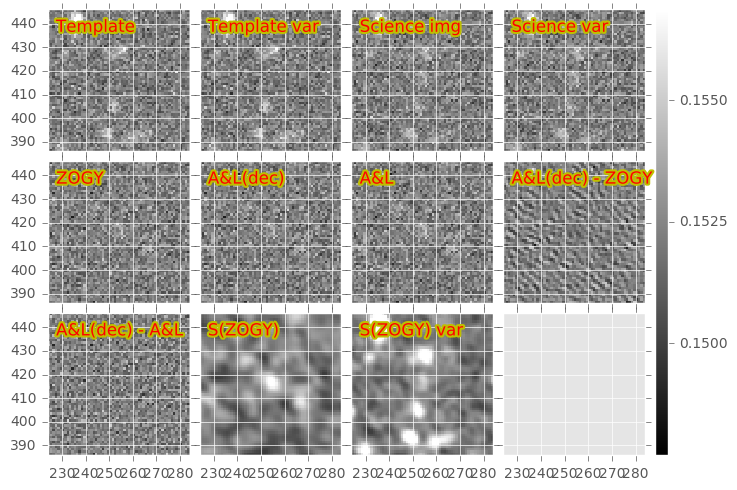

In [6]:
obj.doPlot(centroidCoord=[254,416,30], include_Szogy=True);

In [16]:
print dit.computeClippedImageStats(obj.S_ZOGY.im)
print dit.computeClippedImageStats(obj.S_ZOGY.var)
print dit.computeClippedImageStats(obj.S_ZOGY.im/obj.S_ZOGY.var)

stats(mean=0.00024927275888675442, stdev=0.15355390023979887, min=-0.72460293642984352, max=1.1318173947778991)
stats(mean=0.15229408707182726, stdev=0.00091382321734333378, min=0.14915881766013211, max=0.27856169305831008)
stats(mean=0.0011227642139541908, stdev=1.0020726175942829, min=-4.7723070615729144, max=7.2850409018938489)


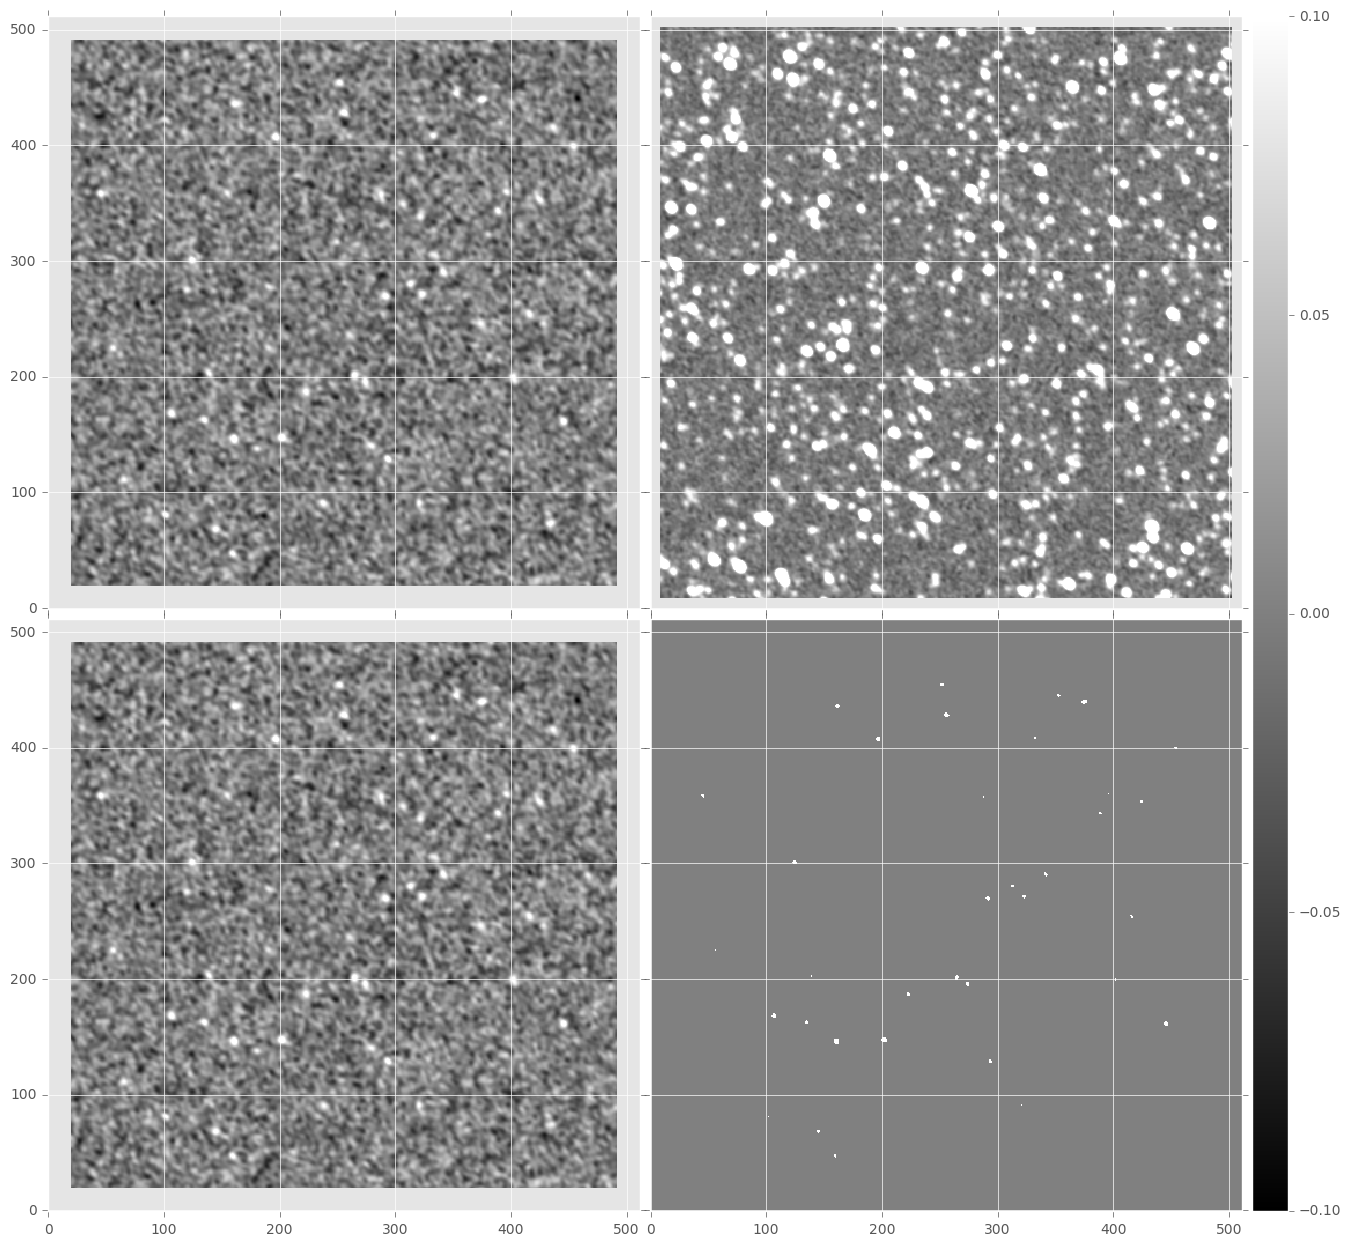

In [18]:
dit.plotImageGrid((obj.S_ZOGY.im, obj.S_ZOGY.var, obj.S_ZOGY.im/obj.S_ZOGY.var,
                  (obj.S_ZOGY.im/obj.S_ZOGY.var > 5.0)*1.0), imScale=8)

In [28]:
tmpExp = dit.Exposure(obj.S_ZOGY.im/obj.S_ZOGY.var, var=obj.S_ZOGY.im*0.+1., psf=obj.S_ZOGY.psf)
src_SZOGY = dit.tasks.doDetection(tmpExp.asAfwExposure(), thresholdType='stdev', doSmooth=False, doMeasure=False)
print len(src_SZOGY)
src_SZOGY2 = dit.tasks.doDetection(obj.S_ZOGY.asAfwExposure(), thresholdType='stdev', doSmooth=False, doMeasure=False)
print len(src_SZOGY2)
src_SZOGY3 = dit.tasks.doDetection(obj.S_ZOGY.asAfwExposure(), thresholdType='pixel_stdev', doSmooth=False, doMeasure=False)
print len(src_SZOGY3)

32
35
0


In [30]:
import lsst.afw.table as afwTable

changedCentroid = obj.getCentroidsCatalog(transientsOnly=True)

srces = src_SZOGY
print len(srces)
srces = srces[~srces['base_PsfFlux_flag']]  # this works!
print len(srces)
matches = afwTable.matchXy(changedCentroid, srces, np.sqrt(1.5))  # these should not need uniquifying
true_pos = len(matches)
false_neg = len(changedCentroid) - len(matches)
false_pos = len(srces) - len(matches)
detections = {'TP': true_pos, 'FN': false_neg, 'FP': false_pos}
detections

32
31


{'FN': 28, 'FP': 9, 'TP': 22}

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import diffimTests_OLD as ditOLD

import warnings
warnings.filterwarnings('ignore')

In [4]:
testResults3 = ditOLD.multi.runTest(flux=620.*np.sqrt(2.), n_varSources=50, n_sources=1000,
                                templateNoNoise=False, skyLimited=False,
                                sky=[300., 300.], sourceFluxRange=(500,30000),
                                remeasurePsfs=[False, False], 
                                zogyImageSpace=False,
                                returnObj=True, printErrs=True)

In [7]:
tr = testResults3
tr['result']

{'ALstack': {'FN': 14, 'FP': 9, 'TP': 36},
 'ALstack_decorr': {'FN': 34, 'FP': 3, 'TP': 16},
 'SZOGY': {'FN': 33, 'FP': 7, 'TP': 17},
 'ZOGY': {'FN': 31, 'FP': 3, 'TP': 19}}

A&L(dec): stats(mean=0.018290959, stdev=24.710978, min=-83.032524, max=107.50542)
ZOGY: stats(mean=0.096949058328436935, stdev=24.357682976402334, min=-118.57813736543534, max=135.62922183880903)
A&L(dec) - ZOGY: stats(mean=0.23832841344011402, stdev=1.7556253531301225, min=-9.995577202645336, max=24.592619462505652)
A&L(dec) - A&L: stats(mean=-0.032347057, stdev=6.7975993, min=-33.896133, max=36.515701)


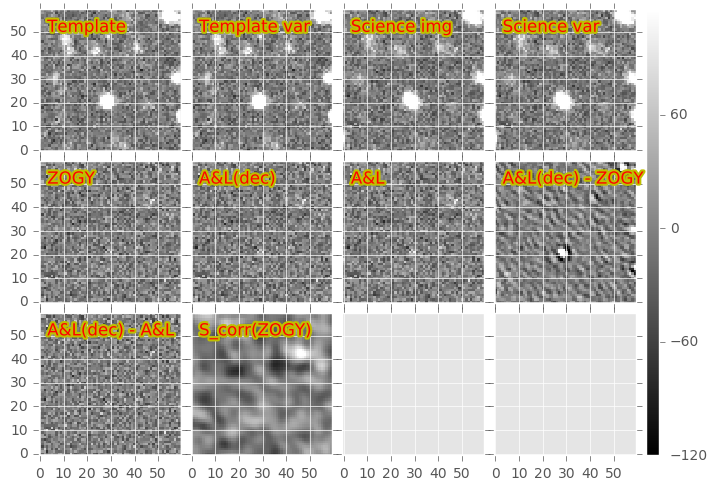

In [8]:
objOLD = tr['obj']
objOLD.doPlot(centroidCoord=[254,416,30], include_Szogy=True);

In [11]:
print ditOLD.computeClippedImageStats(obj.S_ZOGY.im)
print ditOLD.computeClippedImageStats(obj.S_ZOGY.var)
print ditOLD.computeClippedImageStats(obj.S_ZOGY.im/obj.S_ZOGY.var)

stats(mean=0.0037345396182886371, stdev=0.15368714554123256, min=-0.7711092762399514, max=1.1955905394797204)
stats(mean=0.0061903725503505112, stdev=3.7955519503284465e-05, min=0.0060625636041701046, max=0.011467817607776768)
stats(mean=0.57137462714291665, stdev=24.632215581673368, min=-89.152401950843583, max=188.41279718139688)


```
stats(mean=0.00024927275888675442, stdev=0.15355390023979887, min=-0.72460293642984352, max=1.1318173947778991)
stats(mean=0.15229408707182726, stdev=0.00091382321734333378, min=0.14915881766013211, max=0.27856169305831008)
stats(mean=0.0011227642139541908, stdev=1.0020726175942829, min=-4.7723070615729144, max=7.2850409018938489)
```

In [11]:
objOLD.im1 = obj.im1
objOLD.im2 = obj.im2
objOLD.reset()
res = objOLD.runTest(returnSources=True)

A&L(dec): stats(mean=0.27258199, stdev=23.811392, min=-86.330032, max=84.215889)
ZOGY: stats(mean=0.028408863007482278, stdev=24.404021937991061, min=-112.28346122894023, max=136.64797111053838)
A&L(dec) - ZOGY: stats(mean=0.0033039362891112956, stdev=1.7423149666115616, min=-6.7068441961364123, max=6.1186510413133988)
A&L(dec) - A&L: stats(mean=-0.022218991, stdev=6.8077641, min=-34.60733, max=44.168472)


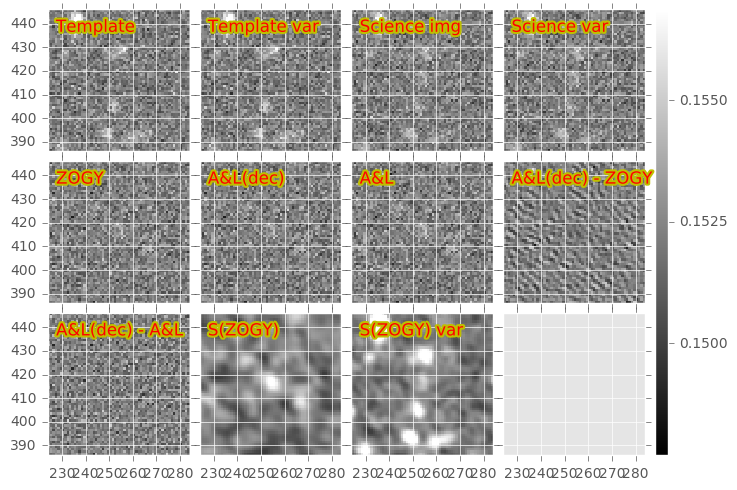

In [12]:
obj.doPlot(centroidCoord=[254,416,30], include_Szogy=True);

A&L(dec): stats(mean=0.34744877, stdev=23.783634, min=-85.883499, max=84.409859)
ZOGY: stats(mean=0.028408863007482278, stdev=24.404021937991061, min=-112.28346122894023, max=136.64797111053838)
A&L(dec) - ZOGY: stats(mean=0.044375919537947305, stdev=1.8809275294713965, min=-7.2782038869580852, max=8.4811540930712113)
A&L(dec) - A&L: stats(mean=-0.025274454, stdev=6.8338623, min=-27.534454, max=44.410355)


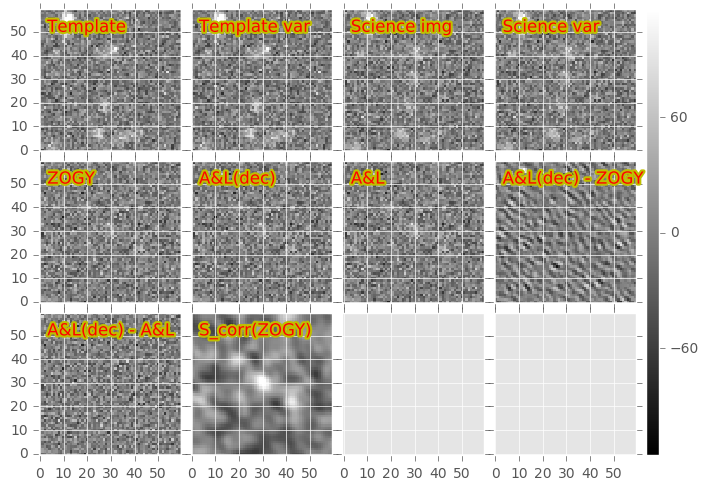

In [13]:
objOLD.doPlot(centroidCoord=[254,416,30], include_Szogy=True);

In [19]:
print dit.computeClippedImageStats(obj.S_ZOGY.im)
print dit.computeClippedImageStats(obj.S_ZOGY.var)
print dit.computeClippedImageStats(obj.S_ZOGY.im/obj.S_ZOGY.var*np.sqrt(300.+300.))
print dit.computeClippedImageStats(objOLD.S_ZOGY.im)
print dit.computeClippedImageStats(objOLD.S_ZOGY.var)
print dit.computeClippedImageStats(objOLD.S_corr_ZOGY.im)

stats(mean=0.00024927275888675442, stdev=0.15355390023979887, min=-0.72460293642984352, max=1.1318173947778991)
stats(mean=0.15229408707182726, stdev=0.00091382321734333378, min=0.14915881766013211, max=0.27856169305831008)
stats(mean=0.027501994256447976, stdev=24.54566598321086, min=-116.89717196734583, max=178.44632964944896)
stats(mean=0.00024927275888675442, stdev=0.15355390023979887, min=-0.72460293642984352, max=1.1318173947778991)
stats(mean=0.0061879906525329495, stdev=3.7130328798130993e-05, min=0.0060605988529840163, max=0.011318477203816853)
stats(mean=0.032587020411953202, stdev=24.539481810184615, min=-117.33295173403813, max=179.23817108500543)


A&L(dec): stats(mean=0.44772378, stdev=24.337048, min=-105.7318, max=87.29847)
ZOGY: stats(mean=0.028408863007482278, stdev=24.404021937991061, min=-112.28346122894023, max=136.64797111053838)
A&L(dec) - ZOGY: stats(mean=0.036317834710961922, stdev=1.9418988322524839, min=-17.633043887751015, max=43.562626513473063)
A&L(dec) - A&L: stats(mean=-0.025274454, stdev=6.8338623, min=-27.534454, max=44.410355)
Added 0: stats(mean=0.027501994256447976, stdev=24.54566598321086, min=-116.89717196734583, max=178.44632964944896)
Added 1: stats(mean=-0.00082770825654840592, stdev=0.099280527546831754, min=-19.4986298402616, max=57.395351882996948)


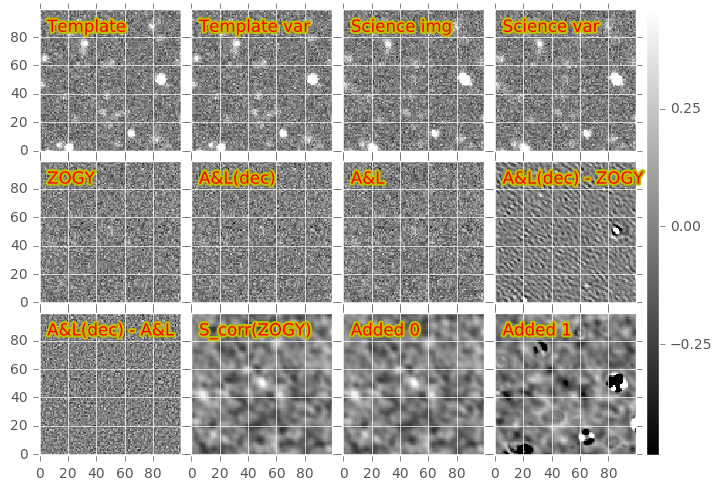

In [28]:
extraImg1 = obj.S_ZOGY.im/obj.S_ZOGY.var*np.sqrt(300.+300.)
extraImg2 = extraImg1 - objOLD.S_corr_ZOGY.im

objOLD.doPlot(centroidCoord=[254,416,50], include_Szogy=True, addedImgs=[extraImg1, extraImg2]);

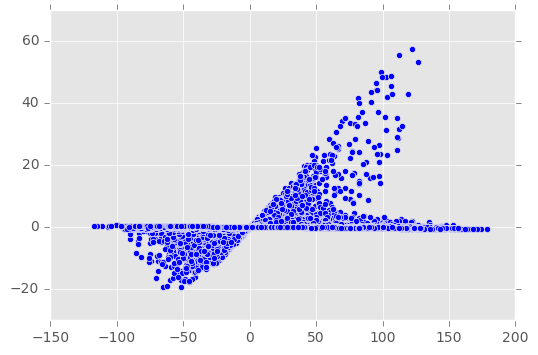

In [29]:
plt.scatter(extraImg1.flatten(), extraImg1.flatten()-objOLD.S_corr_ZOGY.im.flatten())

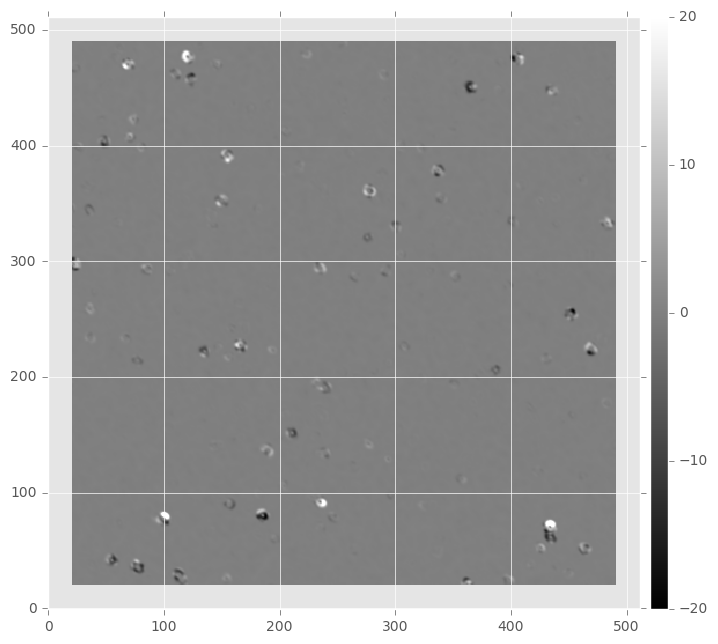

In [30]:
dit.plotImageGrid((extraImg1 - objOLD.S_corr_ZOGY.im,), imScale=8, clim=(-20,20))

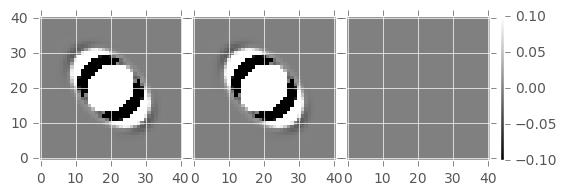

In [32]:
dit.plotImageGrid((obj.S_ZOGY.psf, objOLD.S_corr_ZOGY.psf,
                  obj.S_ZOGY.psf-objOLD.S_corr_ZOGY.psf))